### 1. Reading dataset and pre-processing

In [73]:
# importing all necessary library

import string
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords 
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
import re
import json
import pandas as pd
import spacy
from spacy import displacy
from tqdm import tqdm
from random import sample
import random
import matplotlib.pyplot as plt
import networkx as netx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trushaparam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/trushaparam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/trushaparam/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
root_path = "/Users/trushaparam/Desktop/document_parses"  # sets the path where the data files are stored

# list the files in two subfolders
pdf_files = !ls '/Users/trushaparam/Desktop/document_parses/pdf_json'
pmc_files = !ls '/Users/trushaparam/Desktop/document_parses/pmc_json'

In [3]:
# create two new lists to create the full file path
pdf_files_list = [root_path + "/pdf_json/"+ str(i) for i in pdf_files]
pmc_files_list = [root_path + "/pmc_json/"+ str(i) for i in pmc_files]

In [4]:
# select a random sample of 5000 files from each list
pdf_files_list = sample(pdf_files_list,5000)
pmc_files_list = sample(pmc_files_list, 5000)

# concatenate two lists
file_list = pdf_files_list + pmc_files_list

# random shuffle the order 
random.shuffle(file_list)

To randomize the order so that they are randomly distributed throughtout the file, I have done random shuffle thus providing more representative sample of overall dataset. 

In [5]:
# Define a function named fetch_list that takes a list_file as input.
def fetch_list(list_file):

    # Create empty lists to store data.
    article_authors = [] # List to store article authors.
    body_text = [] # List to store article body text.
    paper_id= [] # List to store article paper IDs.
    title= [] # List to store article titles.

    # Iterate over the input list_file.
    for i in list_file:

        # Open the file in read mode and load its JSON content into a dictionary named data.
        with open(i,'r') as f:
            data = json.load(f)

        # Extract the authors of the article from the metadata dictionary in the data dictionary.
        all_authors = data['metadata']['authors']
        full_auth = []
        for auth in all_authors:
            authors = auth['first'] + ' ' + " ".join(auth['middle']) +' '+ auth['last'] + ' ' + auth['suffix'].strip()  # Construct the full name of each author by concatenating their first name, middle names, last name, and suffix (if any).
            full_auth.append(authors)
        article_authors.append(full_auth)   # Append the list of full author names to the article_authors list.

        # Extract the body text of the article from the data dictionary.
        # Append the list of body text to the body_text list.
        body_text.append([i['text'] for i in data['body_text']])

        # Extract the paper ID of the article from the data dictionary.
        # Append the paper ID to the paper_id list.
        paper_id.append(data['paper_id'])

        # Extract the title of the article from the metadata dictionary in the data dictionary.
        # Append the title to the title list.
        title.append(data['metadata']['title'])

    # Return a tuple of the four lists: paper_id, title, body_text, and article_authors.
    return (paper_id, title, body_text, article_authors)

In [6]:
# fetch the lists of paper IDs, titles, body texts, and authors
paper_id, title, body_text, authors = fetch_list(file_list)

# combine all the body texts into a single string
body_text = [" ".join(text) for text in body_text]

I have following preprocessing [1]:
1) **Punctuation removal:** The first step removes any punctuation from the text data. Punctuation marks like periods, commas, and exclamation points can interfere with NLP analysis, so removing them helps to clean the data.

2) **Tokenization:** The second step breaks the text into individual words, or tokens. This is done using the word_tokenize() function from the nltk library. Tokenization helps to normalize the text and break it down into smaller, more manageable units.

3) **Non-alphanumeric removal:** The third step removes any non-alphanumeric characters from the text data. This step is done using regular expressions to match any character that is not a letter or number. Removing these characters helps to simplify the text and reduce noise in the data.

4) **Stopword removal:** The fourth step removes any stop words from the text data. Stop words are common words that are not usually helpful for NLP analysis, such as "the", "and", and "in". Removing these words helps to reduce the size of the data and focus on the more meaningful words.

5) **Lowercasing:** The fifth step converts all the words in the text to lowercase. This helps to standardize the data and avoid discrepancies in case sensitivity.

6) **Lemmatization:** The final step is lemmatization, which reduces each word in the text to its base or root form. This helps to further normalize the data and reduce the number of unique words that need to be analyzed.

In [7]:
# Pre-processing
def preprocess(file_list):
    
    # Remove punctuation from each line of text
    file_list_punctuation = [line.translate(line.maketrans('', '', string.punctuation)) for line in file_list]

    # Tokenize each line of text into a list of words
    file_list_token = [word_tokenize(text) for text in file_list_punctuation]

    # Remove non-alphanumeric characters from each word in the tokenized list
    file_list_alpha = [[re.sub(r'[^a-zA-Z0-9]','',i)for i in line ] for line in file_list_token]

    # Remove stop words from each list of words
    stop_words = set(stopwords.words('english'))
    file_list_version1 = [[word for word in line if word.lower() not in stop_words]for line in file_list_alpha]

    # Convert all words to lowercase
    file_list_version2 = [[word.lower() for word in line]for line in file_list_version1]

    # Lemmatize each word using WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    file_list = [[lemmatizer.lemmatize(word) for word in line]for line in file_list_version2]

    # Combine the processed words for each line back into a single string
    file_list_final = [" ".join(word) for word in file_list if word !=""]

    return (file_list_final)


In [8]:
# Preprocess the titles
title_pre = preprocess(title)

In [9]:
# Preprocess the body text
body_text_pre = preprocess(body_text)

### 2. Named Entity Recognition and Knowledge Base

Named Entity Recognition [2][4] :

I have break down input files into smaller chunks as to avoid running out of memory while processing. The advantage of using this method is that it allows processing large documents without running into memory issues. The use of chunking enables the NER model to be applied to large amounts of text, which can be useful in many real-world scenarios. Additionally, spacy is a widely used and well-documented library for NLP tasks, and "en_core_web_sm" model has been trained on a large corpus of text, making it a good choice for NER tasks.

In [10]:
# function to break down the doc into smaller chunks
def chunk_strings(file_list):
    text = []   # Initializing an empty list to store text chunks
    chunk = 1000000     # Setting the size of each chunk as 1,000,000 characters

    for string in file_list:    # Looping through each string in the input file list
        if len(string) > 1000000:   # If the length of the string is greater than 1,000,000 characters
            for i in range(0,len(string), chunk):   # Looping through the string in increments of 1,000,000 characters
                chunks = string[i:i+1000000]    # Slicing the string into 1,000,000-character chunks
                for j in chunks:    # Looping through each chunk
                    text.append(j)  # Appending each chunk to the list of text chunks
        else:
            text.append(string)     # If the length of the string is less than or equal to 1,000,000 characters, append it to the list of text chunks
    return text     # Return the list of text chunks

In [11]:
# Chunk the preprocessed body text into 1,000,000-character chunks
chunks_body_text = chunk_strings(body_text_pre)   

In [13]:
 # Chunk the preprocessed titles into 1,000,000-character chunks
chunks_title = chunk_strings(title_pre)   

In [14]:
# Load spacy's pre-trained model for English language
nlp = spacy.load("en_core_web_sm")

# Function to extract named entities from chunks of text
def ner(chunks_title):
    
    entities_list = []  # Initialize an empty list to store named entities
    for string in tqdm(chunks_title):   # Loop through each chunk of text
        document = nlp(string)  # Process the text using the spacy model
        for entity in document.ents:    # Loop through each named entity in the processed document
            # Append the named entity's text, label, description, start and end character positions to the entities list
            entities_list.append((entity.text, entity.label_, spacy.explain(entity.label_), entity.start_char, entity.end_char))
    return entities_list    # Return the list of named entities

# Function to display named entities in a text using spacy's displacy module
def display(text):
    document = nlp(text)    # Process the text using the spacy model
    displacy.render(document, style="ent")  # Use displacy to render the named entities in the text

In [15]:
# Extract named entities from title chunks
entity = ner(chunks_title)
# Display named entities for the first chunk of title text
display_chunks_title = display(chunks_title[0])

100%|██████████| 10000/10000 [00:14<00:00, 686.31it/s]


In [16]:
# Extract named entities from body text chunks
entity = ner(chunks_body_text)
# Display named entities for the first 10000 characters of the first chunk of body text
display_chunks_body_text = display(chunks_body_text[0][0:100])

100%|██████████| 10000/10000 [14:07<00:00, 11.79it/s]


### Simple Knowledge Base [4]

For KB, I'm using ReVerb [3] where I have extracted relations between noun phrases from corpus of text using the ReVerb system and visualize the resulting network of relations. The use of ReVerb system and the visualization of the resulting network are common techniques in NLP and information extraction. The ReVerb system is a popular tool for extracting relations between noun phrases, and the resulting network can be used to gain insights into the structure of the text and the relationships between entities. The use of networkx and matplotlib libraries to construct and visualise the network is also a common approach in data visualisation and analysis. And the benefit of using this methos can provide a more comprehensive understanding of the relationships between entities in text. In addition, it is designed to extract relations that implied based on context. This makes ReVerb a powerful tool for discovering latent relationships between entities that may not be immediately obvious.

In [17]:
# Select the first 10 elements of the body_text list and store them in kb_articles.
kb_articles = body_text[:10]

# Join the elements of the kb_articles list into a single string with space as separator and store it in kb_articles_text.
kb_articles_text = " ".join(kb_articles)

# Open a file named "reverb_data.txt" in write mode and write the content of kb_articles_text to it.
with open("reverb_data.txt", "w") as f:
    f.write(kb_articles_text)

# Run the REVERB tool by invoking the Java program with appropriate command line options.
# Append the output of the tool to a file named "reverb_cmd_data.txt".
! java -Xmx512m -jar reverb-latest.jar reverb_data.txt >> reverb_cmd_data.txt

# Create an empty list named reverb_data_list.
reverb_data_list = []

with open("reverb_cmd_data.txt", "r") as f:     # Open the "reverb_cmd_data.txt" file in read mode.
    for line in f:      # For each line in the file, split the line into words using tab as delimiter.
        words = line.split("\t")
        last_three = [word.rstrip("\n") for word in words[-3:]]     # Extract the last three words of the line, strip newline character from them, and store them in a list.
        reverb_data_list.append(last_three)     # Append the list to the reverb_data_list.


Initializing ReVerb extractor...Done.
Initializing confidence function...Done.
Initializing NLP tools...Done.
Starting extraction.
Extracting from reverb_data.txt
Summary: 1252 extractions, 1000 sentences, 0 files, 3 seconds
Done with extraction.
Summary: 2378 extractions, 1750 sentences, 1 files, 5 seconds


In [78]:
# to show 3 entries from KB 
count = 0
print("Showing 3 example entries in KB: ")
for entity in reverb_data_list:
    entity_1 = entity[0]
    entity_2 = entity[2]
    relation = entity[1]
    print(entity_1, "<--", relation, "-->", entity_2)
    count += 1
    if count == 3:
        break  

Showing 3 example entries in KB: 
diabetes <-- be one of --> the most common noncommunicable diseases
diabetes <-- affect --> # % of adult populations
most patients <-- have --> type # diabetes


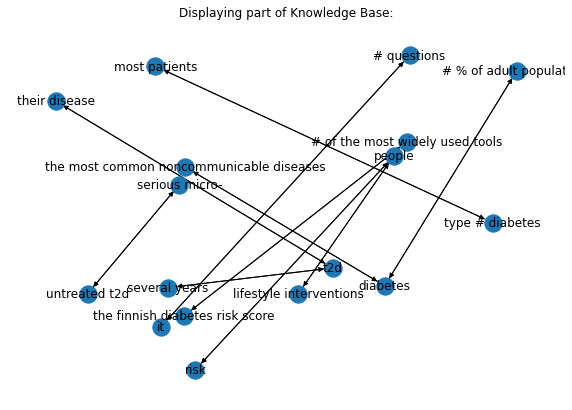

In [79]:
# Define a function named draw_graph that takes a list of REVERB data as input.
def draw_graph(reverb_data_list):

    # Create an empty directed graph using the NetworkX module.
    graph = netx.DiGraph()

    # Iterate over the REVERB data list.
    for i in reverb_data_list:

        # Add two directed edges to the graph, one from the first element of the REVERB data to the third element,
        # and the other from the third element to the first element.
        graph.add_edge(i[0], i[2])
        graph.add_edge(i[2], i[0])

    # Set the size of the figure to (30,60) inches, and show the plot.
    plt.figure(figsize=(10,7))
    plt.title("Displaying part of Knowledge Base:")

    # Draw the graph using NetworkX's random layout algorithm, and show the node labels.
    netx.draw_random(graph, with_labels =True)

# Call the draw_graph function with the first 10 elements of the REVERB data list as input.
draw_graph(reverb_data_list=reverb_data_list[0:10])

### 3. Indexing method [4]

For indexing I have used NER to identify entities. This method captures important information about the content of each paper by identifying the entites that are mentioned in the text. Alongwith that it avoids redundancy by skipping entities that have been already indexed.

In [22]:
def create_indexing(paper_id_list, body_text_list):
    indexing = {}     # Create an empty dictionary to hold the indexing
    paper_uniq = set()      # Create an empty set to hold unique paper IDs
    entity_uniq = set()     # Create an empty set to hold unique entities

    for i,body in enumerate(body_text_list):   # Loop through each body text in the body_text_list
        proc_bdy = nlp(body)   # Process each body text using Spacy's natural language processing
        for ent in proc_bdy.ents:    # Loop through each entity in the processed body text
            if (ent.text in entity_uniq and i in paper_uniq):   # Check if both entity and paper ID have been seen before
                        continue # If both entity and paper already seen, skip it
            else:
                entity_uniq.add(ent.text )    # Add the entity to the set of unique entities
                paper_uniq.add(i)             # Add the paper ID to the set of unique paper IDs
                if ent.text in indexing:     # Check if the entity is already in the indexing
                    indexing[ent.text].append(i)   # If yes, append the current paper ID to the list of papers
                else:
                    indexing[ent.text] = [i]    # If no, create a new entry in the indexing with the current paper ID as the first entry
    return indexing   # Return the final indexing dictionary

In [23]:
# Call the function on the paper IDs and title preprocessed text to create indexing for titles
indexing_title = create_indexing(paper_id_list = paper_id,body_text_list = title_pre)

In [24]:
# Call the function on the paper IDs and body text preprocessed text to create indexing for body texts
indexing_body_text = create_indexing(paper_id_list = paper_id,body_text_list = body_text_pre)

### 4. Text matching utility [4]

The tfidfVectorizer is a good methos for finding relevant articles as it takes into account the frequency of each word in the document, as well as how many documents contain that word. The cosine similarity metric is also good for comparing documents because it is robus to difference in document length and scales well with the number of dimensions. Maybe using "en_core_web_md" can give good cosine similarity score.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def query(question, indexing, num_snippets=5, snippet_length=50):
    relevant_article_index = []
    entity_list = []
    relevant_paper = set()
    preprocessed_question = preprocess([question])[0]
    entities = preprocessed_question.split()
    for entity in entities:
        entity_list.append(entity)
        if entity in indexing:
            temp_list = list(relevant_paper)
            temp_list.extend(indexing[entity])
            relevant_paper = set(temp_list)

    # initialize TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # fit and transform the articles into tf-idf vectors
    suggested_body_texts = [body_text_pre[index] for index in relevant_paper]
    tfidf_matrix = vectorizer.fit_transform(suggested_body_texts)

    # transform the question into a tf-idf vector
    question_tfidf = vectorizer.transform([preprocessed_question])

    # compute the cosine similarity between the question vector and the article vectors
    cosine_similarities = cosine_similarity(tfidf_matrix, question_tfidf)

    # tuple with cosine and relevant_paper and then sort
    cosine_score_with_index = []
    for i, similarity in enumerate(cosine_similarities):
        cosine_score_with_index.append((similarity[0], list(relevant_paper)[i]))
    cosine_score_with_index.sort(reverse=True)

    # get the scores of the most similar articles
    scores = [x[0] for x in cosine_score_with_index]

    # fetch snippets from body_text_pre of the top n indices
    snippets = []
    for index in cosine_score_with_index[:num_snippets]:
        text = body_text_pre[index[1]]
        sentences = text.split('.')
        snippet = sentences[0][:snippet_length] + '...' if len(sentences[0]) > snippet_length else sentences[0]
        snippets.append(snippet)

    # return the article numbers, scores, snippets and entity list
    return (cosine_score_with_index[:num_snippets], scores[:num_snippets], snippets, entity_list)


In [45]:
# question 
question = "is covid 19 in australia?"

# set up lists to store the results of the query
cosine_score_with_indexes = []
cosine_scores = []
body_text_snippets = []

# run the query
indexes_1, scores_1, snippets_1, entity_list = query(question, indexing_body_text)

# store the values in the lists
cosine_score_with_indexes.append(indexes_1)
cosine_scores.append(scores_1)
body_text_snippets.append(snippets_1)

In [52]:
def get_paper_id(indexes):
    # create an empty list 
    paper_id_index = []

    for i in indexes:    # iterate through each list in indexes
        for j in i:
            paper_id_index.append(paper_id[j[1]])   # append corresponding paper_id to paper_id_index
    return paper_id_index   # return the list of paper_ids

# call get_paper_id function
paper_id_index = get_paper_id(cosine_score_with_indexes)

In [54]:
# create an empty list to get paper_id's index and it's relevant cosine score 
paper_id_with_score =[]
for i in range(5):  # iterate through first five elements 
    paper_id_with_score.append((paper_id_index[i],cosine_scores[0][i]))     # append a tuple containing the ith element of paper_id_index and first line in scores list

In [71]:
# my_dict = {paper_id_with_score[0][0]: paper_id_with_score[0][1] }
my_dict ={}


for i in range(5):
    my_dict[paper_id_with_score[i][0]]=paper_id_with_score[0][1]

print("The relevant 3 article number and the score of matching with the questions are: ")
pd.DataFrame({'article_id' : my_dict.keys() , 'score_of_matching' : my_dict.values() })

The relevant 3 article number and the score of matching with the questions are: 


,article_id,score_of_matching
0,PMC8143062,0.143176
1,b6ee305fd24c903d88fd5f60f7d2d511f1dabf73,0.143176
2,69bbe1c417b7629ee5e22b4575f2392e8ce0e137,0.143176
3,PMC8724749,0.143176
4,c4430f2f43a7b40b67db453ad33c830d0cb9eb17,0.143176


### 5. Test utility and test results

In [74]:
# list of example questions
example_questions = ["Is covid 19 similar to TB?",
                     "How to use face masks?",
                     "What is the mortality rate of covid 19?",
                     "What are the symptoms of covid 19?",
                     "What are different coronavirus variants?",
                     "what are the names of Coronavirus vaccines?",
                     "Was covid19 in hungary?",
                     "What  are the preventive measures for covid19?",
                     "Is covid dangerous?",
                     "Whhen was the coronavirus outbreak?",
                    ]

# list of example answer ranks for each questions
example_answer_ranks = [1, 2, 1, 5, 3, 1, 4, 3, 5, 2]

# define a function to calculate MRR(Mean Reciprocal Rank)
def calculate_mrr(queries, answer_ranks):
    rr_scores = []  # initialize an empty list to store rr score
    for i, query in enumerate(queries):     # loop through each questions and it's corresponding answer rank
        rr_score = 1 / answer_ranks[i]  # calculate rr score
        rr_scores.append(rr_score)  # append to store the values
    return rr_scores    # return rr_score

# Test the utility
rr_scores = calculate_mrr(example_questions, example_answer_ranks)

mrr_score = np.mean(rr_scores)  # calculate MRR 
print(f"MRR score for the provided set of questions is {mrr_score}")  # print the mrr score

MRR score for the provided set of questions is 0.5316666666666667


### 6. Simple user interface [5]

In [75]:
# this function takes a query entity as input and returns a list of recognized entity types 
def labels(query_ent):
    entity_types = {
    'year': 'DATE',
    'where': 'LOC',
    'long': 'CARDINAL',
    'money': 'MONEY',
    'law': 'LAW',
    'how many': 'ORDINAL',
    'how much': 'QUANTITY',
    'organization': 'ORG',
    'percent': 'PERCENT',
    'country': 'GPE',
    'city': 'GPE',
    'state': 'GPE',
    'lang': 'LANGUAGE',
    'ian': 'NORP'
    }
    recognized_ent = set()      # set to store recognized entity type
    for ent_type in entity_types:       # loop through the entity types and check if they are in query entity
        if ent_type in query_ent:
            recognized_ent.add(entity_types[ent_type])  # if entity type in query entity, add it's label to the set

    return list(recognized_ent)     # return the list of recognized entity types


In [77]:
def get_relevant_paper_id(cosine_index):
    return [paper_id[cosine_index]]

question = input("What is your question?")      # ask user for a question 
print("Your question: ", question)      # print the user input questions

cosine_score_with_index, scores, snippets, entity_list = query(question, indexing_body_text, num_snippets=3)      # call the query function
question_answer_label = labels(entity_list)     # get label for each entity in the entity list

paper_id_index_lists = []   # create an empty list to store paper_id for eac score
for i in range(3):
    paper_id_user = get_relevant_paper_id(cosine_score_with_index[i][1])
    paper_id_index_lists.append(paper_id_user)

# flatten the list of paper_ids to a single list
paper_id_index_list=[]
for i in paper_id_index_lists:
    paper_id_index_list.extend(i)

# create a dictionary 
dictionary = {"Article_number": paper_id_index_list, "confidence_score": scores, "snippets_of_text": snippets}
dataframe_relevant_answer = pd.DataFrame(dictionary)    # create dataframe from the dictionary 
 
print("The corresponding article number, confidence of the answer and snippet of the relevant text is as follows:")
dataframe_relevant_answer # visualize the corresponding answer

Your question:  what are the variants of covid19?
The corresponding article number, confidence of the answer and snippet of the relevant text is as follows:


,Article_number,confidence_score,snippets_of_text
0,PMC8401729,0.555878,context covid19 pandemic caused severe acute r...
1,ddce5261241d7e2516b2fa3ea74d737824c119dd,0.405469,global pandemic coronavirus disease covid19 cl...
2,b18390141a241fd72c9071c50897a18de75d9169,0.353692,coronavirus disease covid19 caused severe acut...


### 7. References

https://myuni.adelaide.edu.au/courses/86392/pages/module-2-online-learning?module_item_id=2961180 [1]

https://spacy.io/usage/spacy-101 [2]

https://github.com/knowitall/reverb [3]

https://openai.com/blog/chatgpt [4] 

https://www.analyticsvidhya.com/blog/2022/06/custom-named-entity-recognition-using-spacy-v3/ [5]